In [2]:
import os
import pandas as pd
import janitor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import math
%matplotlib inline

In [9]:
print(os.getcwd())

C:\Users\radvanyi\PycharmProjects\ZSI_analytics\PATSTAT


In [10]:
outdir="EU_CH_scope/v2_"

appln = pd.read_csv(f"{outdir}/tls_201_scope.csv")

appln_title = pd.read_csv(f"{outdir}/tls_202_scope.csv")

pers = pd.read_csv(f"{outdir}/tls_206_scope.csv")

appln_pers = pd.read_csv(f"{outdir}/tls_207_scope.csv")

appln_cpc = pd.read_csv(f"{outdir}/tls_224_scope.csv")

cpc_desc = pd.read_csv(r"CPC_data/cpc_defs.csv")

country_defs = pd.read_csv(f"{outdir}/table_tls801.csv").rename(columns={"st3_name":"Country"})

In [71]:
ch_codes = ["CN","HK","MO","TW"]
ch_names = country_defs[country_defs["ctry_code"].isin(ch_codes)]["Country"].unique()

In [90]:
country_defs

ctry_code iso_alpha3                           Country organisation_flag   
0                                                  unknown                 Y  \
1          AD        AND                           Andorra                     
2          AE        ARE              United Arab Emirates                     
3          AF        AFG                       Afghanistan                     
4          AG        ATG               Antigua and Barbuda                     
..        ...        ...                               ...               ...   
237        YE        YEM                             Yemen                     
238        YU        YUG  Yugoslavia/Serbia and Montenegro                     
239        ZA        ZAF                      South Africa                     
240        ZM        ZMB                            Zambia                     
241        ZW        ZWE                          Zimbabwe                     

         continent eu_member epo_member oecd_member discontinued  
0              NaN                                                
1           Europe                                                
2             Asia                                                
3             Asia                                                
4    North America                                                
..             ...       ...        ...         ...          ...  
237           Asia                                                
238         Europe                                             Y  
239         Africa                                                
240         Africa                                                
241         Africa                                                

[242 rows x 9 columns]

In [91]:
appln.head()

appln_id appln_auth  appln_nr appln_kind appln_filing_date   
0  340657036         EP  12000117         A         2012-01-09  \
1  340982410         EP  12151915         A         2012-01-20   
2  341078960         EP  12700310         A         2012-01-11   
3  341078962         EP  12700311         A         2012-01-11   
4  341127772         EP  12700372         A         2012-01-02   

   appln_filing_year appln_nr_original ipr_type receiving_office   
0               2012          12000117       PI                   \
1               2012          12151915       PI                    
2               2012          12700310       PI                    
3               2012          12700311       PI                    
4               2012          12700372       PI                    

   internat_appln_id  ... earliest_publn_date earliest_publn_year   
0                  0  ...          2013-07-10                2013  \
1                  0  ...          2012-07-25                2012   
2          340778427  ...          2014-01-22                2014   
3          340778431  ...          2014-01-22                2014   
4          340460188  ...          2014-10-15                2014   

  earliest_pat_publn_id granted  docdb_family_id  inpadoc_family_id   
0             407623142       Y         45507394          340657036  \
1             365158710       Y         45531220          340982410   
2             413564969       Y         45491582          340778427   
3             413564970       Y         45491583          340778431   
4             421840120       Y         45495923          340460188   

  docdb_family_size  nb_citing_docdb_fam  nb_applicants nb_inventors  
0                 3                    6              1            2  
1                 2                   16              2            6  
2                 3                    2              1            1  
3                 3                    3              1            1  
4                 4                    8              1            2  

[5 rows x 26 columns]

In [92]:
appln[["appln_id","appln_nr","appln_nr_original"]].nunique()

appln_id             64266
appln_nr             63242
appln_nr_original    62651
dtype: int64

In [76]:
appln_ctry = appln_pers.merge(pers[["person_id","person_ctry_code"]],
                 on="person_id").merge(country_defs[["Country","ctry_code"]],
                                       left_on="person_ctry_code", right_on="ctry_code").drop(columns=["ctry_code","person_ctry_code"])
appln_ctry["Country_Type"] = "EU"
appln_ctry.loc[appln_ctry["Country"].isin(ch_names),"Country_Type"] = "CH"
appln_ctry

person_id   appln_id  applt_seq_nr  invt_seq_nr  Country Country_Type
0               1  340314532             1            0  Finland           EU
1               1  413601768             1            0  Finland           EU
2             128  332888018             1            0  Finland           EU
3             128  333546132             1            0  Finland           EU
4             128  334765473             1            0  Finland           EU
...           ...        ...           ...          ...      ...          ...
274039   80730412  554759601             2            0   Latvia           EU
274040   83499411  571805168             0            2   Latvia           EU
274041   84881241  569497458             0            1   Latvia           EU
274042   85405745  568976675             0            5   Latvia           EU
274043   85718222  568976675             0            6   Latvia           EU

[274044 rows x 6 columns]

Text(0.5, 0, 'Year')

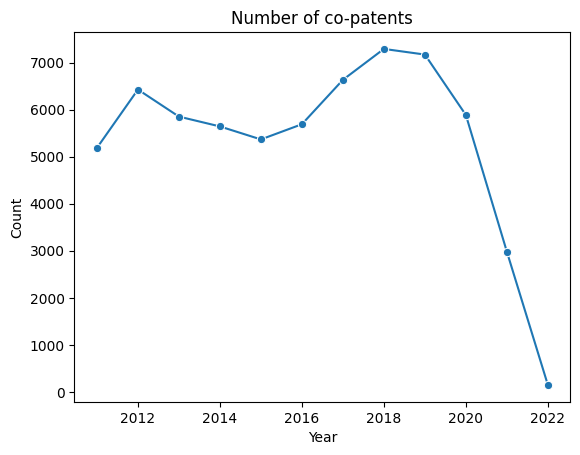

In [63]:
data = appln.groupby(["appln_filing_year"], as_index=False)["appln_id"].count()
data
g = sns.lineplot(data, x="appln_filing_year", y="appln_id", marker="o")
g.set_title("Number of co-patents")
g.set_ylabel("Count")
g.set_xlabel("Year")

In [103]:

eu_invt = appln_ctry[((appln_ctry["Country_Type"]=="EU") & (appln_ctry['invt_seq_nr']>0))]["appln_id"].unique()
eu_applt = appln_ctry[((appln_ctry["Country_Type"]=="EU") & (appln_ctry['applt_seq_nr']>0))]["appln_id"].unique()
ch_invt = appln_ctry[((appln_ctry["Country_Type"]=="CH" )& (appln_ctry['invt_seq_nr']>0))]["appln_id"].unique()
ch_applt = appln_ctry[((appln_ctry["Country_Type"]=="CH") & (appln_ctry['applt_seq_nr']>0))]["appln_id"].unique()

appln["co_inventors"] = appln["appln_id"].isin(eu_invt) & appln["appln_id"].isin(ch_invt)
appln["co_applicants"] = appln["appln_id"].isin(eu_applt) & appln["appln_id"].isin(ch_applt)

appln["foreign ownership (CH inventors; EU owned)"] = (appln["appln_id"].isin(eu_applt) & appln["appln_id"].isin(ch_invt) &
                                             ~appln["appln_id"].isin(eu_invt) & ~appln["appln_id"].isin(ch_applt))
appln["foreign ownership (EU inventors; CH owned)"] = (appln["appln_id"].isin(ch_applt) & appln["appln_id"].isin(eu_invt) &
                                             ~appln["appln_id"].isin(ch_invt)& ~appln["appln_id"].isin(eu_applt))

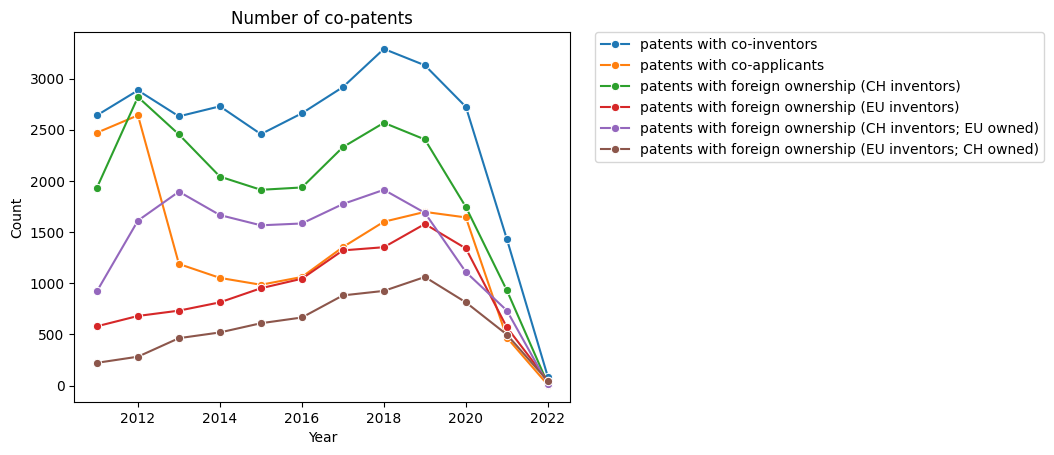

In [104]:
cols = ["co_inventors","co_applicants",
        "foreign ownership (CH inventors)",
        "foreign ownership (EU inventors)",
        "foreign ownership (CH inventors; EU owned)",
        "foreign ownership (EU inventors; CH owned)"]

for c in cols:
    data = appln[appln[c]==True].groupby(["appln_filing_year"], as_index=False)["appln_id"].count()
    g = sns.lineplot(data, x="appln_filing_year", y="appln_id", marker="o")
g.set_title(f"Number of co-patents")
g.set_ylabel("Count")
g.set_xlabel("Year")
g.legend(handles=g.lines,labels=["patents with " + c.replace("_","-") for c in cols], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

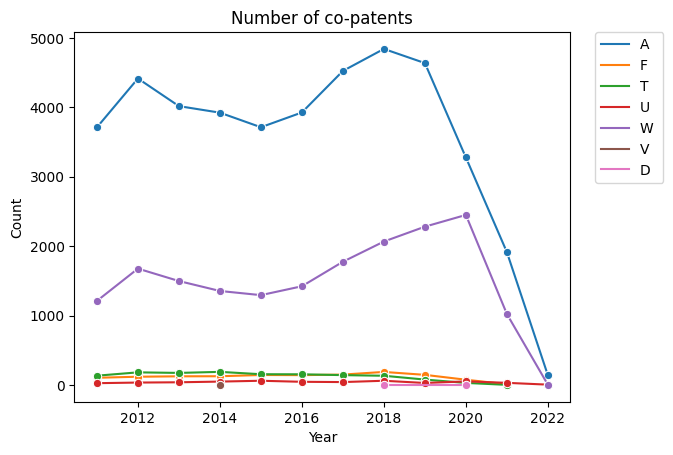

In [102]:
data = appln.groupby(["appln_filing_year","appln_kind"], as_index=False)["appln_id"].count()
data
g = sns.lineplot(data, x="appln_filing_year", y="appln_id", marker="o", hue="appln_kind")
g.set_title("Number of co-patents")
g.set_ylabel("Count")
g.set_xlabel("Year")
g.legend(title=None,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Year')

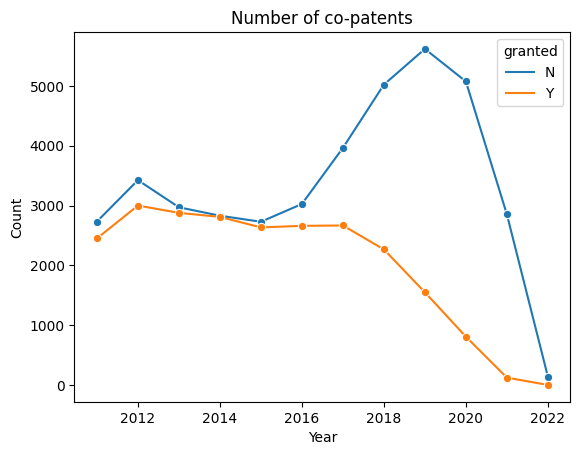

In [17]:
data = appln.groupby(["appln_filing_year","granted"], as_index=False)["appln_id"].count()
data
g = sns.lineplot(data, x="appln_filing_year", y="appln_id", hue="granted", marker="o")
g.set_title("Number of co-patents")
g.set_ylabel("Count")
g.set_xlabel("Year")

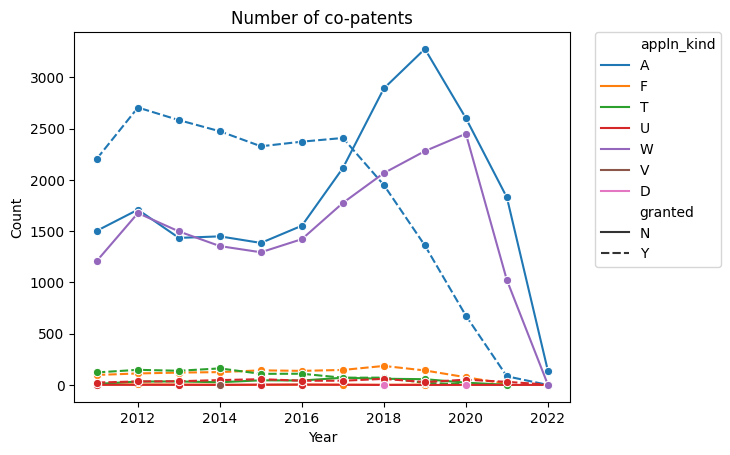

In [46]:
data = appln.groupby(["appln_filing_year","granted","appln_kind"], as_index=False)["appln_id"].count()
g = sns.lineplot(data, x="appln_filing_year", y="appln_id", hue="appln_kind",style="granted", marker="o")
g.set_title("Number of co-patents")
g.set_ylabel("Count")
g.set_xlabel("Year")
g.legend(title=None,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [60]:
data

appln_filing_year granted appln_kind  appln_id
0                2011       N         A       1504
1                2011       N         F          6
2                2011       N         T         11
3                2011       N         U          2
4                2011       N         W       1211
..                ...     ...        ...       ...
93               2022       N         A        140
94               2022       N         U          1
95               2022       N         W          4
96               2022       Y         A          1
97               2022       Y         U          4

[98 rows x 4 columns]

In [61]:
p_data

appln_filing_year granted appln_kind  appln_id   sum   percent
0                2011       N         A       1504  3711  0.405282
1                2011       Y         A       2207  3711  0.594718
2                2011       N         F          6   104  0.057692
3                2011       Y         F         98   104  0.942308
4                2011       N         T         11   134  0.082090
..                ...     ...        ...       ...   ...       ...
93               2022       N         A        140   141  0.992908
94               2022       Y         A          1   141  0.007092
95               2022       N         U          1     5  0.200000
96               2022       Y         U          4     5  0.800000
97               2022       N         W          4     4  1.000000

[98 rows x 6 columns]

Text(0.5, 0, 'Year')

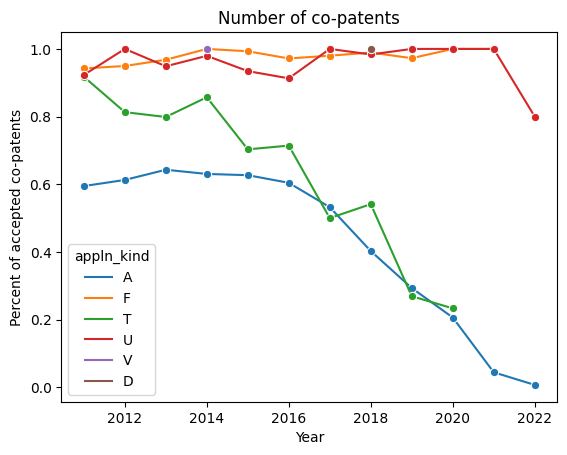

In [62]:
perc = data.groupby(['appln_filing_year',"appln_kind"], as_index=False)["appln_id"].sum().rename(columns={"appln_id":"sum"})
p_data = data.merge(perc, on = ['appln_filing_year',"appln_kind"])
p_data["percent"] = p_data["appln_id"]/p_data["sum"]
# p_data
g = sns.lineplot(p_data[p_data["granted"]=="Y"], x="appln_filing_year", y="percent", hue="appln_kind", marker="o")
g.set_title("Number of co-patents")
g.set_ylabel("Percent of accepted co-patents")
g.set_xlabel("Year")
g.legend(title=None,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [54]:
data.groupby(['appln_filing_year',"appln_kind"])["appln_id"].apply(lambda x:100 * x / float(x.sum()))

appln_filing_year  appln_kind    
2011               A           0      40.528160
                               5      59.471840
                   F           1       5.769231
                               6      94.230769
                   T           2       8.208955
                                        ...    
2022               A           93     99.290780
                               96      0.709220
                   U           94     20.000000
                               97     80.000000
                   W           95    100.000000
Name: appln_id, Length: 98, dtype: float64

In [49]:
p_data

NameError: name 'p_data' is not defined

In [39]:
data

appln_filing_year granted appln_kind  appln_id     percent
0                2011       N         A       1504   40.528160
1                2011       N         F          6   59.471840
2                2011       N         T         11    5.769231
3                2011       N         U          2   94.230769
4                2011       N         W       1211    8.208955
..                ...     ...        ...       ...         ...
93               2022       N         A        140   99.290780
94               2022       N         U          1    0.709220
95               2022       N         W          4   20.000000
96               2022       Y         A          1   80.000000
97               2022       Y         U          4  100.000000

[98 rows x 5 columns]

In [23]:
sorted(appln["appln_kind"].unique())

['A ', 'D ', 'F ', 'T ', 'U ', 'V ', 'W ']

In [ ]:
for kind in sorted(appln["appln_kind"].unique()):
    sub_data = data[data["appln_kind"]==kind]

# Granted patents

In [ ]:
granted = appln[appln["granted"]=="Y"]["appln_id"].unique()
appln_pers=[appln_pers["appln_id"].isin(granted)]

In [93]:
patstat_collabs = appln_pers.merge(pers, on="person_id")
patstat_collabs = patstat_collabs.merge(country_defs, left_on="person_ctry_code", right_on="ctry_code")
patstat_collabs = patstat_collabs.groupby("appln_id",as_index=False)["Country"].unique().explode('Country')

In [95]:
country_collab = patstat_collabs[patstat_collabs["Country"].isin(ch_names)]["Country"].value_counts().reset_index()
country_collab["percent"] = country_collab["count"]/patstat_collabs["appln_id"].nunique()
country_collab["weight"] = country_collab["count"]/patstat_collabs["appln_id"].size
country_collab

Country  count   percent    weight
0                     China  18189  0.849160  0.400665
1  Taiwan Province Of China   2667  0.124510  0.058748
2          Hong Kong, China    859  0.040103  0.018922
3         Macao SAR (China)     13  0.000607  0.000286

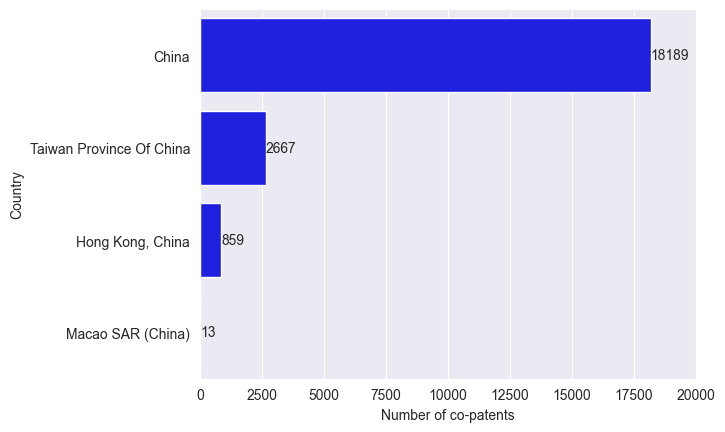

In [96]:
data = country_collab
g = sns.barplot(data, x="count", y="Country", color="blue")
g.set_xlim(0,20000)
g.set_ylabel("Country")
g.set_xlabel("Number of co-patents")
for i in g.containers:
    g.bar_label(i,)

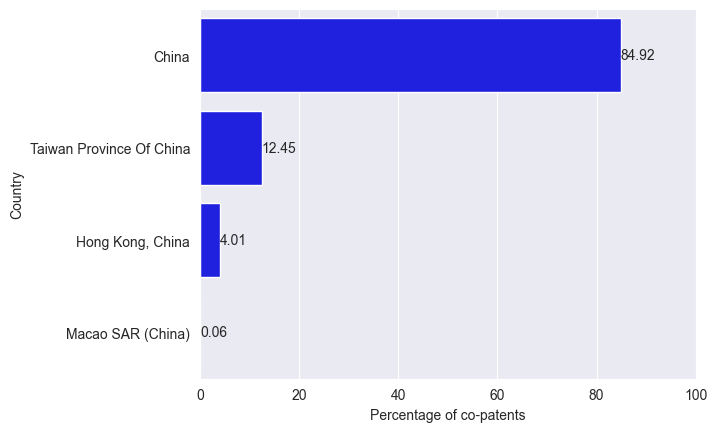

In [97]:
data = country_collab
data["percent_round"] = (data["percent"]*100).round(2)
g = sns.barplot(data, x="percent_round", y="Country", color="blue")
g.set_xlim(0,100)
g.set_ylabel("Country")
g.set_xlabel("Percentage of co-patents")
for i in g.containers:
    # g.bar_label(i,fmt='%.2f%%')
    g.bar_label(i,fmt='%.2f')

In [98]:
country_collab = patstat_collabs[~patstat_collabs["Country"].isin(ch_names)]["Country"].value_counts().reset_index()
country_collab["percent"] = country_collab["count"]/patstat_collabs["appln_id"].nunique()
country_collab["weight"] = country_collab["count"]/patstat_collabs["appln_id"].size
country_collab

Country  count   percent    weight
0       Germany   7248  0.338375  0.159658
1        Sweden   3679  0.171755  0.081041
2        France   3450  0.161064  0.075996
3   Netherlands   2734  0.127638  0.060224
4       Finland   1377  0.064286  0.030332
5       Belgium   1056  0.049300  0.023261
6         Italy   1052  0.049113  0.023173
7       Ireland    628  0.029318  0.013834
8       Denmark    525  0.024510  0.011565
9         Spain    478  0.022316  0.010529
10      Austria    439  0.020495  0.009670
11       Poland    277  0.012932  0.006102
12   Luxembourg    170  0.007937  0.003745
13       Greece    111  0.005182  0.002445
14      Czechia    100  0.004669  0.002203
15     Portugal     64  0.002988  0.001410
16      Hungary     48  0.002241  0.001057
17      Romania     48  0.002241  0.001057
18       Cyprus     37  0.001727  0.000815
19     Bulgaria     36  0.001681  0.000793
20     Slovakia     32  0.001494  0.000705
21        Malta     26  0.001214  0.000573
22    Lithuania     15  0.000700  0.000330
23      Croatia     13  0.000607  0.000286
24     Slovenia     12  0.000560  0.000264
25      Estonia     10  0.000467  0.000220
26       Latvia      4  0.000187  0.000088

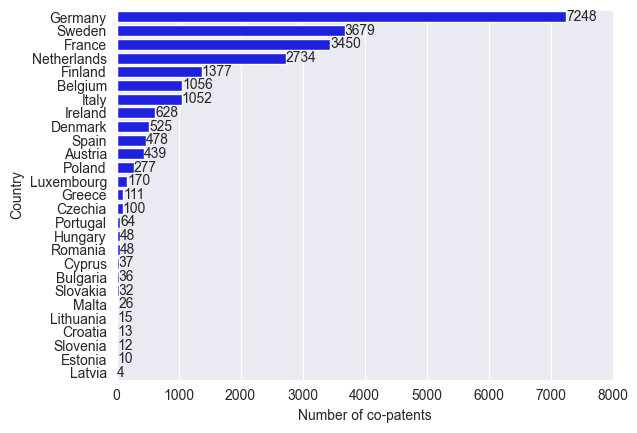

In [99]:
data = country_collab
g = sns.barplot(data, x="count", y="Country", color="blue")
g.set_xlim(0,8000)
g.set_ylabel("Country")
g.set_xlabel("Number of co-patents")
for i in g.containers:
    g.bar_label(i,)

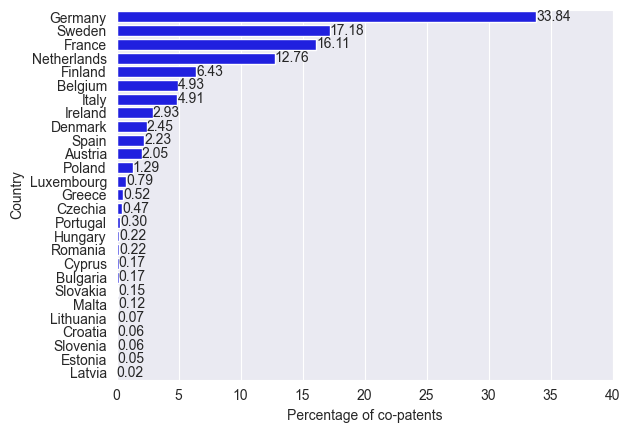

In [100]:
data = country_collab
data["percent_round"] = (data["percent"]*100).round(2)
g = sns.barplot(data, x="percent_round", y="Country", color="blue")
g.set_xlim(0,40)
g.set_ylabel("Country")
g.set_xlabel("Percentage of co-patents")
for i in g.containers:
    # g.bar_label(i,fmt='%.2f%%')
    g.bar_label(i,fmt='%.2f')

# Pivot country - year

In [106]:
record_col = "appln_id"
patstat_collabs_y=patstat_collabs.merge(appln[[record_col,"appln_filing_year"]], on="appln_id")
patstat_collabs_y

appln_id  Country  appln_filing_year
0      340657036  Denmark               2012
1      340657036    China               2012
2      340982410  Denmark               2012
3      340982410    China               2012
4      341078960  Germany               2012
...          ...      ...                ...
45392  575326930    China               2021
45393  575399552   Sweden               2020
45394  575399552    China               2020
45395  575406608  Germany               2014
45396  575406608    China               2014

[45397 rows x 3 columns]

In [111]:
countall = patstat_collabs_y.groupby("appln_filing_year", as_index=False)[record_col].nunique()
data = patstat_collabs_y.groupby("appln_filing_year", as_index=False)["Country"].value_counts().merge(countall, on="appln_filing_year")
data["percent"] = data["count"]/data[record_col]
data_ch = data[data["Country"].isin(ch_names)]
data_ch

appln_filing_year           Country  count  appln_id   percent
0                 2012             China   2581      3001  0.860047
1                 2012           Germany    888      3001  0.295901
2                 2012            France    653      3001  0.217594
3                 2012            Sweden    473      3001  0.157614
4                 2012       Netherlands    406      3001  0.135288
..                 ...               ...    ...       ...       ...
264               2022             China      4         5  0.800000
265               2022       Netherlands      2         5  0.400000
266               2022             Spain      2         5  0.400000
267               2022  Hong Kong, China      1         5  0.200000
268               2022           Czechia      1         5  0.200000

[269 rows x 5 columns]

Text(95.7222222222222, 0.5, '')

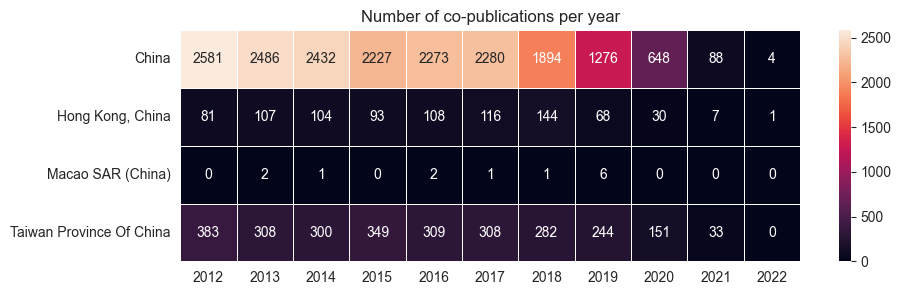

In [116]:
plt.figure(figsize=(10,3))
g = sns.heatmap(pd.pivot_table(data_ch,columns="appln_filing_year", index="Country", values="count").fillna(0).astype(int),
            annot=True, fmt=".0f",linewidth=.5)
g.set_title("Number of co-patents per year")
g.set_xlabel("")
g.set_ylabel("")

Text(95.7222222222222, 0.5, '')

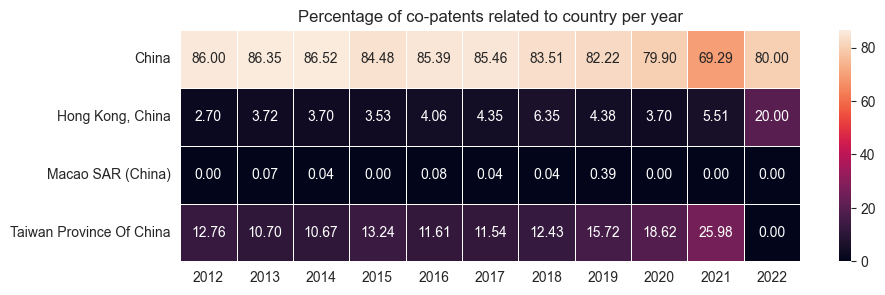

In [118]:
plt.figure(figsize=(10,3))
g = sns.heatmap(pd.pivot_table(data_ch,columns="appln_filing_year", index="Country", values="percent").fillna(0)*100,
            annot=True, fmt=".2f",linewidth=.5)
g.set_title("Percentage of co-patents related to country per year")
g.set_xlabel("")
g.set_ylabel("")

In [112]:
data_eu = data[~data["Country"].isin(ch_names)]
data_eu

appln_filing_year      Country  count  appln_id   percent
1                 2012      Germany    888      3001  0.295901
2                 2012       France    653      3001  0.217594
3                 2012       Sweden    473      3001  0.157614
4                 2012  Netherlands    406      3001  0.135288
6                 2012      Finland    257      3001  0.085638
..                 ...          ...    ...       ...       ...
262               2021      Hungary      1       127  0.007874
263               2021      Croatia      1       127  0.007874
265               2022  Netherlands      2         5  0.400000
266               2022        Spain      2         5  0.400000
268               2022      Czechia      1         5  0.200000

[231 rows x 5 columns]

Text(95.72222222222221, 0.5, '')

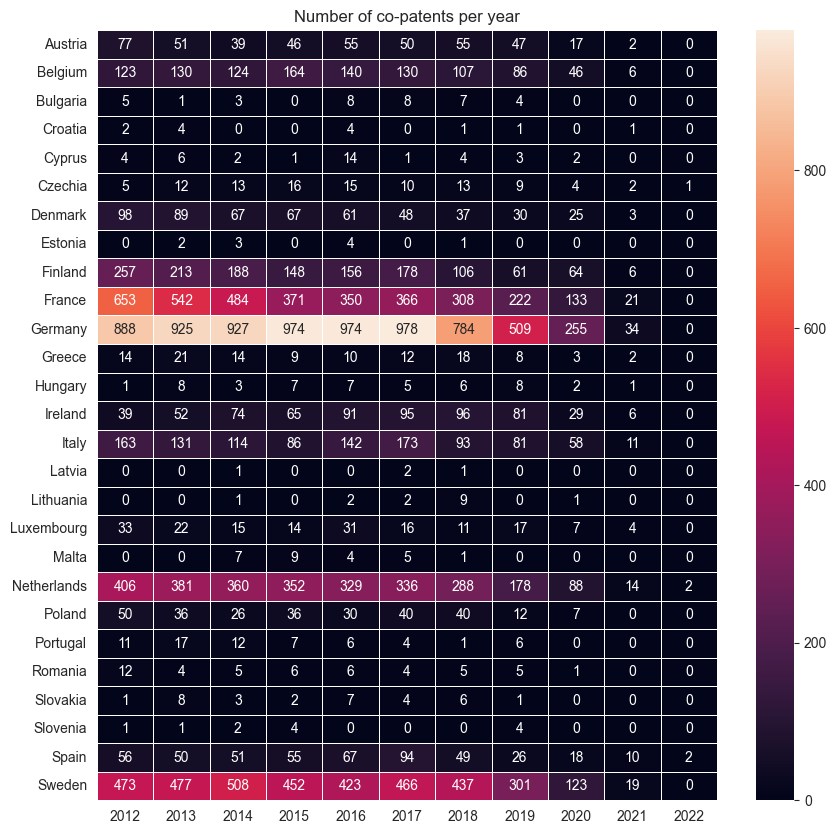

In [121]:
plt.figure(figsize=(10,10))
g = sns.heatmap(pd.pivot_table(data_eu,columns="appln_filing_year", index="Country", values="count").fillna(0).astype(int),
            annot=True, fmt=".0f",linewidth=.5)
g.set_title("Number of co-patents per year")
g.set_xlabel("")
g.set_ylabel("")

Text(95.72222222222221, 0.5, '')

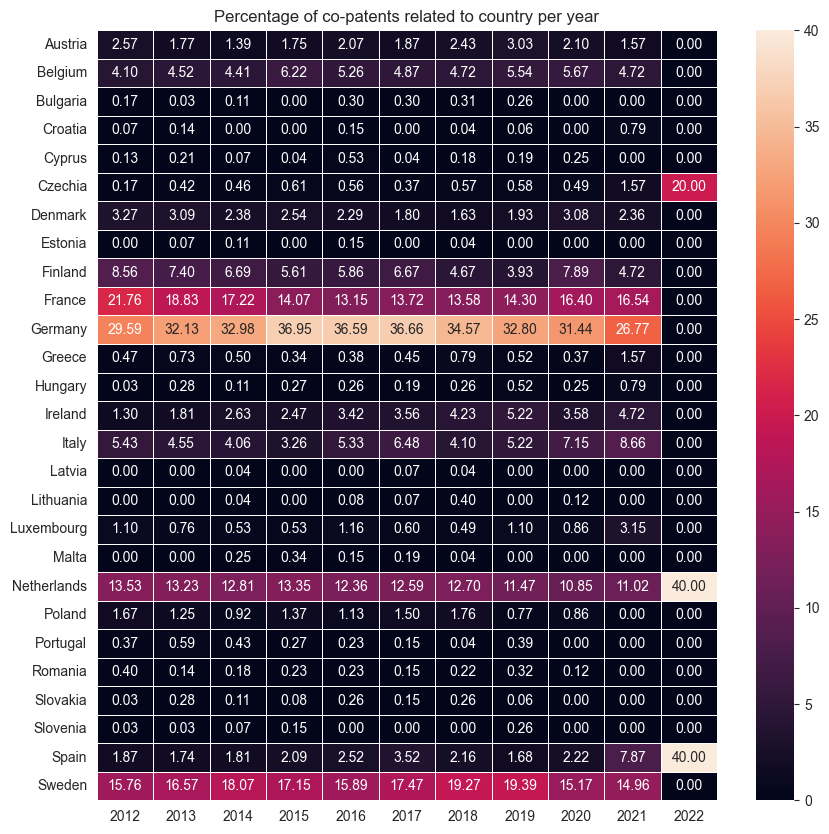

In [123]:
plt.figure(figsize=(10,10))
g = sns.heatmap(pd.pivot_table(data_eu,columns="appln_filing_year", index="Country", values="percent").fillna(0)*100,
            annot=True, fmt=".2f",linewidth=.5)
g.set_title("Percentage of co-patents related to country per year")
g.set_xlabel("")
g.set_ylabel("")

# Let's see about 'organizations'

In [ ]:
# harmonized entities (sector and country too)

In [181]:
pers_han = pers[["person_id","han_id","han_name","psn_sector","person_ctry_code"]].drop_duplicates()
pers_han["psn_sector"].fillna("UNKNOWN", inplace=True)
pers_han = pers_han.sort_values(by="psn_sector", ascending=True)
pers_han.drop(columns="person_id", inplace=True)
pers_han = pers_han.groupby("han_id", as_index=False)[["han_name","psn_sector","person_ctry_code"]].agg(
    lambda x: pd.Series.mode(x)[0])
pers_han = pers_han.merge(country_defs,left_on="person_ctry_code",right_on="ctry_code")

In [182]:
patstat_collabs = appln_pers.merge(pers, on="person_id")
patstat_collabs = patstat_collabs.merge(country_defs, left_on="person_ctry_code", right_on="ctry_code")
org_collabs =  patstat_collabs[[record_col,"han_id","han_name","psn_sector","Country"]].drop_duplicates()
org_collabs["psn_sector"].fillna("UNKNOWN", inplace=True)
org_collabs

appln_id     han_id                      han_name  psn_sector Country
0      352908776    1663881                       L OREAL     COMPANY  France
1      419627340    1663881                       L OREAL     COMPANY  France
2      422411429    1663881                       L OREAL     COMPANY  France
3      439807462    1663881                       L OREAL     COMPANY  France
4      441685575    1663881                       L OREAL     COMPANY  France
...          ...        ...                           ...         ...     ...
87656  488889994    1590343              KERBEJ YUROP LTD     COMPANY   Malta
87657  472247962  153591744  Van Rooij, Reinhart Cornelis     UNKNOWN  Latvia
87658  505769448  157946198         VINGOVATOVS, Aleksejs     UNKNOWN  Latvia
87659  481190056    3652317             VAVILOVS VALERIJS  INDIVIDUAL  Latvia
87660  554759601    3652317             VAVILOVS VALERIJS  INDIVIDUAL  Latvia

[87073 rows x 5 columns]

In [183]:
# China
org_collabs_ch = org_collabs[org_collabs["Country"].isin(ch_names)]["han_id"].value_counts().reset_index()
org_collabs_ch["percent"] = org_collabs_ch["count"]/org_collabs[record_col].nunique()
org_collabs_ch["weight"] = org_collabs_ch["count"]/org_collabs[record_col].size
org_collabs_ch = org_collabs_ch.merge(pers_han, on='han_id')
org_collabs_ch["org"] = org_collabs_ch["han_name"].str.strip() + " ("+org_collabs_ch["person_ctry_code"]+")"
org_collabs_ch

han_id  count   percent    weight   
0        1337324   1980  0.092437  0.022740  \
1          62077    406  0.018954  0.004663   
2      111166343    176  0.008217  0.002021   
3        1912470    174  0.008123  0.001998   
4        3697072    172  0.008030  0.001975   
...          ...    ...       ...       ...   
21413  149475428      1  0.000047  0.000011   
21414  149475432      1  0.000047  0.000011   
21415  149475629      1  0.000047  0.000011   
21416  149475736      1  0.000047  0.000011   
21417  182805176      1  0.000047  0.000011   

                                        han_name  psn_sector person_ctry_code   
0                             HUAWEI TECH CO LTD     COMPANY               CN  \
1      TAIWAN SEMICONDUCTOR MANUFACTURING CO LTD     COMPANY               TW   
2                                    Liu, Jinhua  INDIVIDUAL               CN   
3                                   MEDIATEK INC     COMPANY               TW   
4             NINGBO GEELY AUTOMOBILE R&D CO LTD     COMPANY               CN   
...                                          ...         ...              ...   
21413                                 CHEN, Yuli     UNKNOWN               CN   
21414                                  CHEN, Zhi     UNKNOWN               CN   
21415                                    Du, Jun     UNKNOWN               CN   
21416                                Chunlin, Wu     UNKNOWN               CN   
21417                        Killine Optical Ltd     UNKNOWN               MO   

      ctry_code iso_alpha3                   Country organisation_flag   
0            CN        CHN                     China                    \
1            TW        TWN  Taiwan Province Of China                     
2            CN        CHN                     China                     
3            TW        TWN  Taiwan Province Of China                     
4            CN        CHN                     China                     
...         ...        ...                       ...               ...   
21413        CN        CHN                     China                     
21414        CN        CHN                     China                     
21415        CN        CHN                     China                     
21416        CN        CHN                     China                     
21417        MO        MAC         Macao SAR (China)                     

      continent eu_member epo_member oecd_member discontinued   
0          Asia                                                \
1          Asia                                                 
2          Asia                                                 
3          Asia                                                 
4          Asia                                                 
...         ...       ...        ...         ...          ...   
21413      Asia                                                 
21414      Asia                                                 
21415      Asia                                                 
21416      Asia                                                 
21417      Asia                                                 

                                                  org  
0                             HUAWEI TECH CO LTD (CN)  
1      TAIWAN SEMICONDUCTOR MANUFACTURING CO LTD (TW)  
2                                    Liu, Jinhua (CN)  
3                                   MEDIATEK INC (TW)  
4             NINGBO GEELY AUTOMOBILE R&D CO LTD (CN)  
...                                               ...  
21413                                 CHEN, Yuli (CN)  
21414                                  CHEN, Zhi (CN)  
21415                                    Du, Jun (CN)  
21416                                Chunlin, Wu (CN)  
21417                        Killine Optical Ltd (MO)  

[21418 rows x 17 columns]

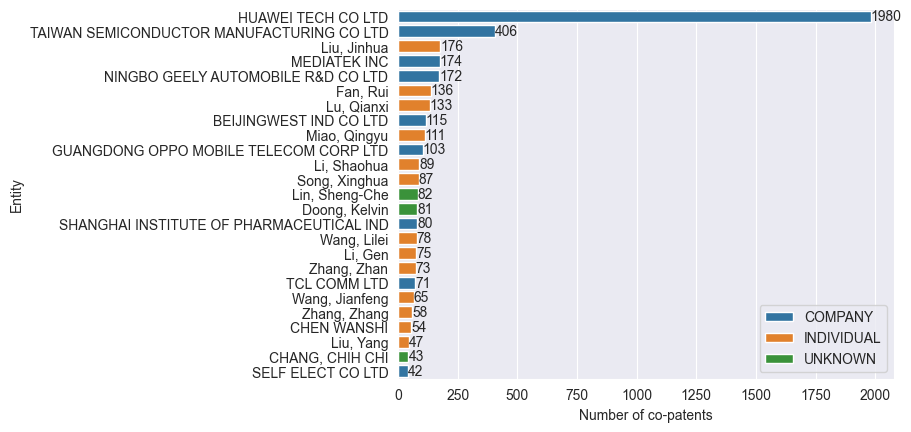

In [184]:
data = org_collabs_ch[0:25]
g = sns.barplot(data, x="count", y="han_name", hue="psn_sector", dodge=False)
g.set_ylabel("Entity")
g.set_xlabel("Number of co-patents")
for i in g.containers:
    g.bar_label(i,)
g.legend(title=None)

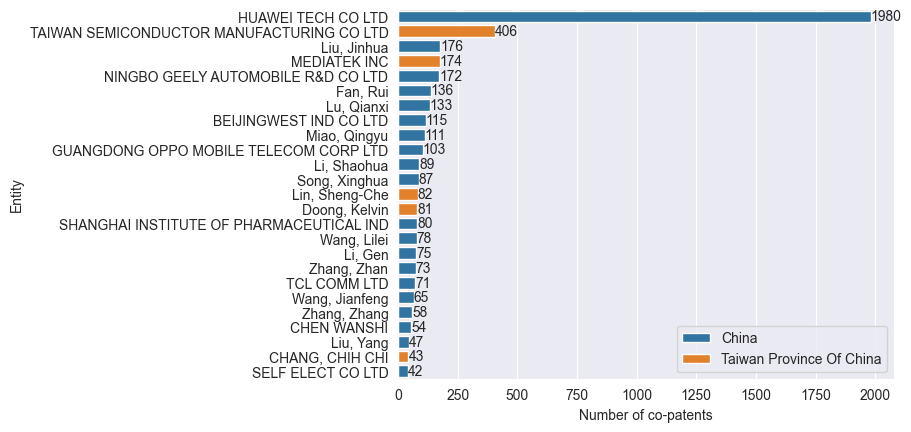

In [185]:
g = sns.barplot(data, x="count", y="han_name", hue="Country", dodge=False)
g.set_ylabel("Entity")
g.set_xlabel("Number of co-patents")
for i in g.containers:
    g.bar_label(i,)
g.legend(title=None, loc=4)

In [186]:
# Eu
org_collabs_eu = org_collabs[~org_collabs["Country"].isin(ch_names)]["han_id"].value_counts().reset_index()
org_collabs_eu["percent"] = org_collabs_eu["count"]/org_collabs[record_col].nunique()
org_collabs_eu["weight"] = org_collabs_eu["count"]/org_collabs[record_col].size
org_collabs_eu = org_collabs_eu.merge(pers_han, on='han_id')
org_collabs_eu

han_id  count   percent    weight                     han_name   
0          13378   1821  0.085014  0.020913  TELEFON AB LM ERICSSON PUBL  \
1          68848    471  0.021989  0.005409               ALCATEL LUCENT   
2        2562294    445  0.020775  0.005111               NOKIA TECH LTD   
3         228842    403  0.018814  0.004628                      BASF SE   
4        2125445    372  0.017367  0.004272                   NOKIA CORP   
...          ...    ...       ...       ...                          ...   
19100  107891047      1  0.000047  0.000011          Goldacker, Thorsten   
19101  176254977      1  0.000047  0.000011           Dietrich, Tiantian   
19102  176256380      1  0.000047  0.000011            LAJFELD Ferdinand   
19103  176327671      1  0.000047  0.000011             GALEANO Karolina   
19104  174748097      1  0.000047  0.000011               Chen, Yunzheng   

       psn_sector person_ctry_code ctry_code iso_alpha3  Country   
0         COMPANY               SE        SE        SWE   Sweden  \
1         COMPANY               FR        FR        FRA   France   
2         COMPANY               FI        FI        FIN  Finland   
3         COMPANY               DE        DE        DEU  Germany   
4         COMPANY               FI        FI        FIN  Finland   
...           ...              ...       ...        ...      ...   
19100  INDIVIDUAL               DE        DE        DEU  Germany   
19101     UNKNOWN               DE        DE        DEU  Germany   
19102     UNKNOWN               DE        DE        DEU  Germany   
19103     UNKNOWN               DE        DE        DEU  Germany   
19104     UNKNOWN               DE        DE        DEU  Germany   

      organisation_flag continent eu_member epo_member oecd_member   
0                          Europe         Y          Y           Y  \
1                          Europe         Y          Y           Y   
2                          Europe         Y          Y           Y   
3                          Europe         Y          Y           Y   
4                          Europe         Y          Y           Y   
...                 ...       ...       ...        ...         ...   
19100                      Europe         Y          Y           Y   
19101                      Europe         Y          Y           Y   
19102                      Europe         Y          Y           Y   
19103                      Europe         Y          Y           Y   
19104                      Europe         Y          Y           Y   

      discontinued  
0                   
1                   
2                   
3                   
4                   
...            ...  
19100               
19101               
19102               
19103               
19104               

[19105 rows x 16 columns]

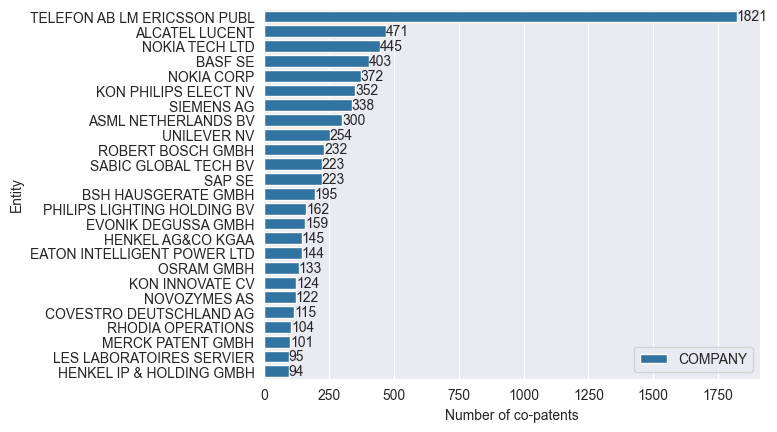

In [187]:
data = org_collabs_eu[0:25]
g = sns.barplot(data, x="count", y="han_name", hue="psn_sector", dodge=False)
g.set_ylabel("Entity")
g.set_xlabel("Number of co-patents")
for i in g.containers:
    g.bar_label(i,)
g.legend(title=None)

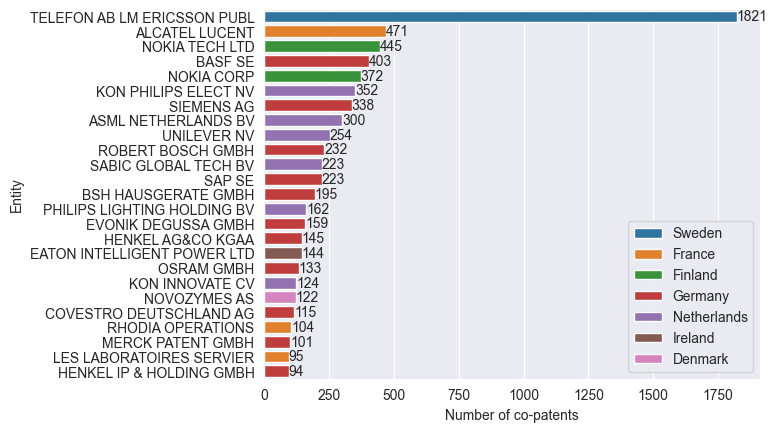

In [188]:
g = sns.barplot(data, x="count", y="han_name", hue="Country", dodge=False)
g.set_ylabel("Entity")
g.set_xlabel("Number of co-patents")
for i in g.containers:
    g.bar_label(i,)
g.legend(title=None, loc=4)

# Patent classes?